Episode 1000/1000. Retour de l'épisode :1000.0

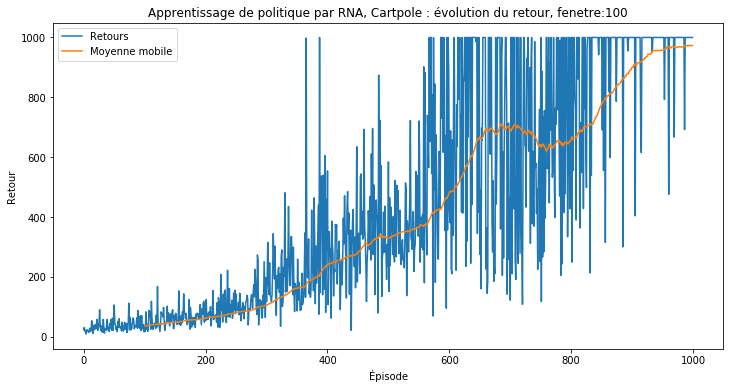

In [8]:
%matplotlib inline
# -*- coding: utf-8 -*-
"""
AR Apprentissage de politique REINFORCE par RNA
Application Cartpole
"""
import numpy as np
import matplotlib.pyplot as plt
import gym
from itertools import count
import torch
from torch import nn
from torch import optim

env = gym.make('CartPole-v0')
env._max_episode_steps = 1000

dim_etat = env.observation_space.shape[0]
nb_actions = env.action_space.n
rna_preference_action = nn.Sequential(
            nn.Linear(dim_etat, 64), 
            nn.ReLU(), 
            nn.Linear(64,nb_actions),
            nn.Softmax(dim=-1))

def calculer_retours_escomptes(recompenses, gamma=0.99):
    """ Calculer les retours escomptés à partir des récompenses pour chaque t"""
    recompenses_escomptees = np.array([gamma**t * recompenses[t] for t in range(len(recompenses))])
    retours_escomptees = recompenses_escomptees[::-1].cumsum()[::-1]
    return retours_escomptees 

def reinforce(env,rna_preference_action,nombre_episodes=1000,taille_lot=10, gamma=0.99):
    """ Apprentissage de la politique par l'algoritme REINFORCE
    La fonction pi est représenté par le RNA rna_preference_action"""
    retours = []
    lot_retours_escomptes = []
    lot_actions = []
    lot_etats = []
    lot_compteur = 1
    optimiseur = optim.Adam(rna_preference_action.parameters(),lr=0.01)
    ensemble_actions = np.arange(env.action_space.n)
    
    for episode in range(nombre_episodes):
        etat = env.reset()
        etats = []
        recompenses = []
        actions = []
        for t in count():
            probabilites_actions = rna_preference_action(torch.FloatTensor(etat)).detach().numpy()
            action = np.random.choice(ensemble_actions, p=probabilites_actions)
            etat_suivant, recompense, fin_episode, _ = env.step(action)
            etats.append(etat)
            recompenses.append(recompense)
            actions.append(action)
            etat = etat_suivant
            
            if fin_episode:
                lot_retours_escomptes.extend(calculer_retours_escomptes(recompenses, gamma))
                lot_etats.extend(etats)
                lot_actions.extend(actions)
                lot_compteur += 1
                retours.append(sum(recompenses))
                
                if lot_compteur == taille_lot:
                    # Apprentissage à partir du lot 
                    optimiseur.zero_grad()
                    lot_etats_tensor = torch.FloatTensor(lot_etats)
                    lot_retours_escomptes_tensor = torch.FloatTensor(lot_retours_escomptes)
                    lot_actions_tensor_long = torch.LongTensor(lot_actions)
                    
                    # Calculer le cout
                    lot_log_prob_actions = torch.log(rna_preference_action(torch.FloatTensor(lot_etats_tensor)))
                    lot_logprobs_actions_choisies = lot_retours_escomptes_tensor * lot_log_prob_actions[np.arange(len(lot_actions_tensor_long)), lot_actions_tensor_long]
                    cout = -lot_logprobs_actions_choisies.mean()
                    
                    # Calculer gradients
                    cout.backward()
                    optimiseur.step()
                    
                    lot_retours_escomptes = []
                    lot_actions = []
                    lot_etats = []
                    lot_compteur = 1
                break
        print("\rEpisode {}/{}. Retour de l'épisode :{}".format(episode+1, nombre_episodes,retours[episode] ), end="")
    return retours

retours = reinforce(env, rna_preference_action)

def afficher_retours(retours, fenetre=10):
    """
    Afficher l'évolution des retours avec le temps
    """
    plt.figure(figsize=(12,6))
    plt.plot(retours,label="Retours")
    retour_moyen_fenetre=[np.mean(retours[i:i+fenetre]) for i in range(len(retours)-fenetre)]
    plt.plot(np.arange(fenetre,len(retours)),retour_moyen_fenetre,label="Moyenne mobile")
    plt.xlabel("Épisode")
    plt.ylabel("Retour")
    plt.title("Apprentissage de politique par RNA, Cartpole : évolution du retour, fenetre:"+str(fenetre))
    plt.legend(loc='upper left')
    plt.show()

afficher_retours(retours, fenetre=100)

In [5]:
ensemble_actions = np.arange(env.action_space.n)
for i_episode in range(5):
    etat = env.reset()
    for t in range(200):
        env.render()
        probabilites_actions = rna_preference_action(torch.FloatTensor(etat)).detach().numpy()
        action = np.random.choice(ensemble_actions, p=probabilites_actions)
        etat_suivant, recompense, fin, info = env.step(action)
        if fin :
            print("Épisode terminé après {} étapes".format(t+1))
            break
        etat=etat_suivant
env.close()


Épisode terminé après 200 étapes
Épisode terminé après 200 étapes
Épisode terminé après 200 étapes
Épisode terminé après 200 étapes
Épisode terminé après 200 étapes
